In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from cmdstanpy import CmdStanModel
from matplotlib import pyplot as plt

# Load and inspect data

In [2]:
df = pd.read_csv("data/data-salary-2.txt")
print(len(df))
df.head(5)

40


,X,Y,KID
0,7,457,1
1,10,482,1
2,16,518,1
3,25,535,1
4,5,427,1


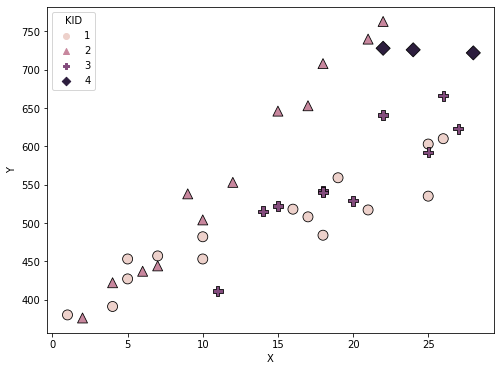

In [3]:
def scatter_plot(ax, df):
    sns.scatterplot(
        ax=ax, 
        data=df, x="X", y="Y", 
        style="KID", hue="KID", 
        markers=['o', '^', 'P', 'D'],
        s=100,
        edgecolor='k', linewidths=10
    )


fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
scatter_plot(ax, df)
fig.show()

# Single line for all companies

In [4]:
model8_1 = CmdStanModel(stan_file="model/model8-1.stan")
print(model8_1)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /workdir/chap08/model/model8-1


CmdStanModel: name=model8-1
	 stan_file=/workdir/chap08/model/model8-1.stan
	 exe_file=/workdir/chap08/model/model8-1
	 compiler_optons=stanc_options=None, cpp_options=None


In [5]:
data8_1 = {
    "N": len(df),
    "X": df['X'].values,
    "Y": df['Y'].values
}

fit8_1 = model8_1.sample(data=data8_1)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4


In [6]:
summary8_1 = fit8_1.summary()
summary8_1

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-184.1340,0.035854,1.26386,-186.6270,-183.8210,-182.7410,1242.57,4551.55,1.00159
a,376.3490,0.613060,24.37690,336.4310,376.2960,416.3970,1581.07,5791.46,1.00094
b,11.0274,0.035406,1.39463,8.7214,11.0046,13.3238,1551.56,5683.36,1.00154
s_Y,68.4061,0.198175,8.28136,56.1904,67.4537,82.8621,1746.25,6396.51,1.00013


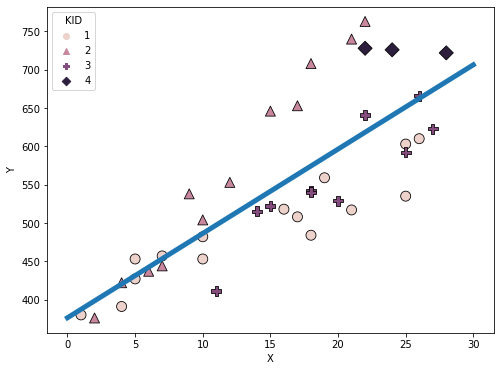

In [7]:
# Corresponding to Fig 8.1 left (difference : the line is calculated from MCMC median of parameters)

xx = np.linspace(0, 30, 11)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
scatter_plot(ax, df)
ax.plot(xx, summary8_1.loc["a", "50%"] + summary8_1.loc["b", "50%"]*xx, linewidth=5)
fig.show()

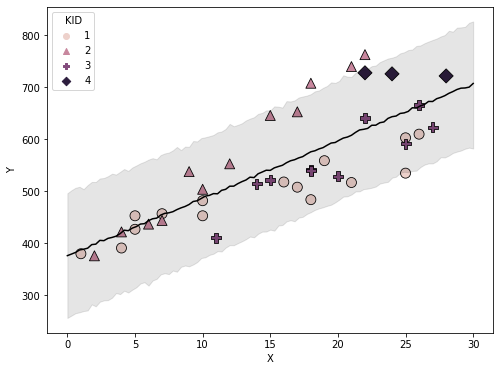

In [8]:
xx = np.linspace(0, 30, 101)
y_pred_samples = np.zeros((len(xx), len(fit8_1.stan_variable("a"))))
for i, x in enumerate(xx):
    y_base = fit8_1.stan_variable("a") + fit8_1.stan_variable("b") * x
    y_pred_samples[i] = np.random.normal(loc=y_base, scale=fit8_1.stan_variable("s_Y"))
y_pred_percentiles = np.percentile(y_pred_samples, [5.0, 50.0, 95.0], axis=1)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
scatter_plot(ax, df)
ax.plot(xx, y_pred_percentiles[1], "k-")
ax.fill_between(xx, y_pred_percentiles[0], y_pred_percentiles[2], color='k', alpha=0.1)
fig.show()

# Separate regression line for each company

In [9]:
model8_2 = CmdStanModel(stan_file="model/model8-2.stan")
print(model8_2)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /workdir/chap08/model/model8-2


CmdStanModel: name=model8-2
	 stan_file=/workdir/chap08/model/model8-2.stan
	 exe_file=/workdir/chap08/model/model8-2
	 compiler_optons=stanc_options=None, cpp_options=None


In [10]:
data8_2 = {
    "N": len(df),
    "K": 4,
    "X": df['X'].values,
    "Y": df['Y'].values,
    "KID": df["KID"].values
}

fit8_2 = model8_2.sample(data=data8_2)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1


In [11]:
summary8_2 = fit8_2.summary()
summary8_2

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-148.076,0.072706,2.44459,-152.586,-147.657,-144.809,1130.52,825.801,1.00165
a[1],387.000,0.270000,14.00000,363.000,388.000,410.000,2781.00,2032.000,1.00000
a[2],328.000,0.320000,17.00000,300.000,328.000,357.000,2817.00,2058.000,1.00000
a[3],314.000,0.660000,34.00000,259.000,314.000,370.000,2623.00,1916.000,1.00000
a[4],751.000,3.000000,155.00000,492.000,754.000,1004.000,2728.00,1993.000,1.00000
b[1],7.500,0.016000,0.87000,6.100,7.500,9.000,2844.00,2077.000,1.00000
b[2],20.000,0.024000,1.30000,18.000,20.000,22.000,2787.00,2036.000,1.00000
b[3],12.000,0.033000,1.70000,9.600,12.000,15.000,2592.00,1893.000,1.00000
b[4],-1.000,0.120000,6.30000,-11.000,-1.200,9.400,2722.00,1988.000,1.00000


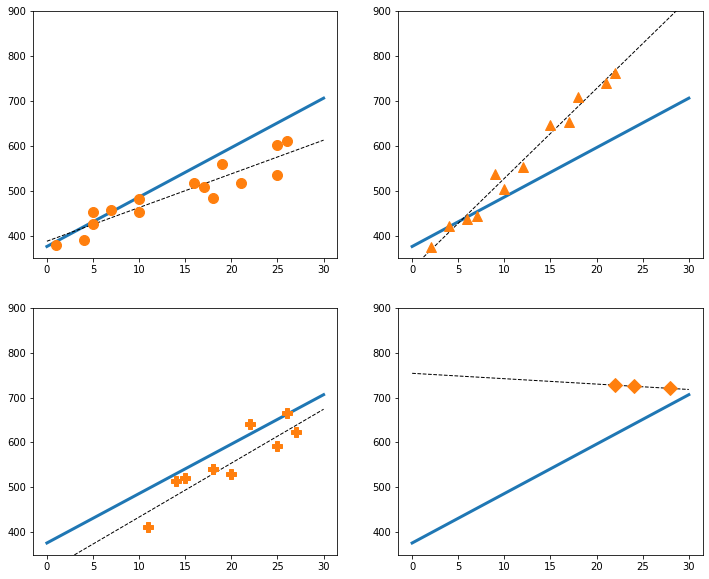

In [12]:
# Corresponding to Fig 8.1 right (difference : the lines are calculated from MCMC median of parameters)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
styles = ['o', '^', 'P', 'D']

xx = np.linspace(0, 30, 11)
for i, ax in enumerate(np.ravel(axes), start=1):
    df_filtered = df[df["KID"]==i]
    ax.plot(xx, summary8_1.loc["a", "50%"] + summary8_1.loc["b", "50%"]*xx, linewidth=3)
    ax.plot(xx, summary8_2.loc[f"a[{i}]", "50%"] + summary8_2.loc[f"b[{i}]", "50%"]*xx, linewidth=1, linestyle="--", color="k")
    ax.plot(df_filtered["X"], df_filtered["Y"], styles[i-1], markersize=10)
    ax.set_ylim(350,900)

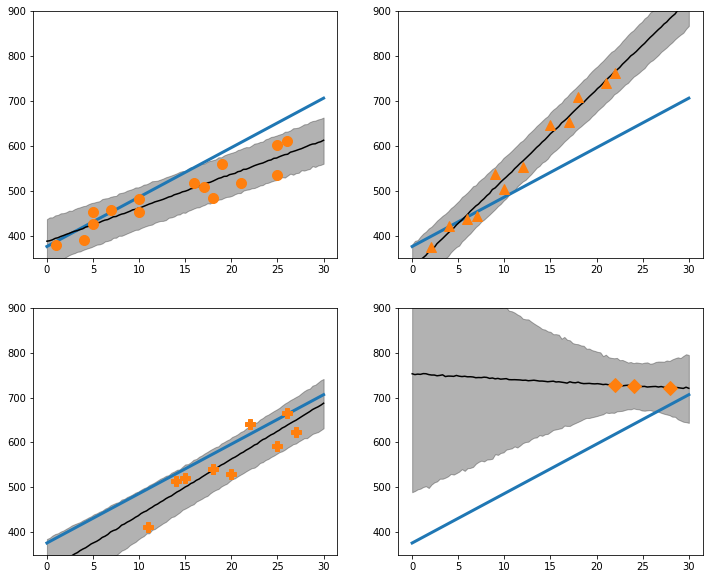

In [13]:
# exercise (1)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
styles = ['o', '^', 'P', 'D']

xx = np.linspace(0, 30, 101)
for KID, ax in enumerate(np.ravel(axes), start=1):
    df_filtered = df[df["KID"]==KID]
    ax.plot(xx, summary8_1.loc["a", "50%"] + summary8_1.loc["b", "50%"]*xx, linewidth=3)

    y_pred_samples = np.zeros((len(xx), len(fit8_2.stan_variable("a"))))
    for i, x in enumerate(xx):
        y_base = fit8_2.stan_variable("a")[:, KID - 1] + fit8_2.stan_variable("b")[:, KID - 1] * x
        y_pred_samples[i] = np.random.normal(loc=y_base, scale=fit8_2.stan_variable("s_Y"))
    y_pred_percentiles = np.percentile(y_pred_samples, [5.0, 50.0, 95.0], axis=1)
    
    ax.plot(xx, y_pred_percentiles[1], "k-")
    ax.fill_between(xx, y_pred_percentiles[0], y_pred_percentiles[2], color="k", alpha=0.3)

    ax.plot(df_filtered["X"], df_filtered["Y"], styles[KID-1], markersize=10)

    ax.set_ylim(350,900)

# Hierarchical model

In [14]:
def simulate():
    N = 40
    K = 4
    N_k = [15, 12, 10, 3] # 各会社に勤務している人数
    a0 = 350
    b0 = 12
    s_a = 60
    s_b = 4
    s_Y = 25

    X = np.random.randint(0, 36, size=N)
    KID = np.repeat(np.arange(1, K+1, 1), N_k)


    a = s_a * np.random.randn(K) + a0
    b = s_b * np.random.randn(K) + b0
    df = pd.DataFrame({
        "X": X,
        "KID": KID,
        "a": a[KID-1],
        "b": b[KID-1]
    })
    df["Y"] = s_Y*np.random.randn(N) + df["a"] + df["b"]*df["X"]
    
    return df, a, b

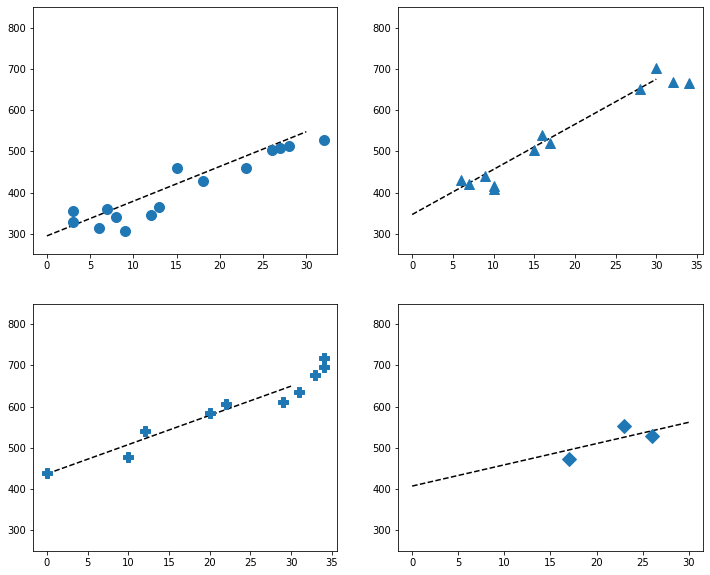

In [15]:
# Fig 8.2

df_simulated, a_simulated, b_simulated = simulate()

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
xx = np.linspace(0, 30, 11)
styles = ['o', '^', 'P', 'D']


xx = np.linspace(0, 30, 11)
for i, ax in enumerate(np.ravel(axes), start=1):
    df_filtered = df_simulated[df_simulated["KID"]==i]
    ax.plot(xx, a_simulated[i-1] + xx*b_simulated[i-1], 'k--')
    ax.plot(df_filtered["X"], df_filtered["Y"], styles[i-1], markersize=10)
    ax.set_ylim(250, 850)

In [16]:
model8_3 = CmdStanModel(stan_file="model/model8-3.stan")
# model8_3 = CmdStanModel(stan_file="model/model8-4.stan")
print(model8_3)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /workdir/chap08/model/model8-3


CmdStanModel: name=model8-3
	 stan_file=/workdir/chap08/model/model8-3.stan
	 exe_file=/workdir/chap08/model/model8-3
	 compiler_optons=stanc_options=None, cpp_options=None


In [17]:
data8_3 = {
    "N": len(df),
    "K": 4,
    "X": df["X"].values,
    "Y": df["Y"].values,
    "KID": df["KID"].values
}

fit8_3 = model8_3.sample(data=data8_3)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2


In [18]:
summary8_3 = fit8_3.summary()
summary8_3

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-173.0760,0.149492,3.48647,-179.27000,-172.7400,-167.8790,543.920,163.388,1.00415
a0,384.5510,7.956610,146.24100,242.88600,367.0830,582.6660,337.819,101.477,1.01047
b0,11.9968,0.378874,8.08053,0.25872,12.4351,22.2621,454.874,136.640,1.01529
ak[1],-1.3000,7.900000,146.00000,-198.00000,12.0000,142.0000,339.000,102.000,1.00000
ak[2],-50.0000,8.000000,147.00000,-251.00000,-30.0000,88.0000,336.000,101.000,1.00000
ak[3],-60.0000,8.100000,150.00000,-267.00000,-38.0000,76.0000,345.000,104.000,1.00000
ak[4],96.0000,7.800000,170.00000,-54.00000,58.0000,384.0000,472.000,142.000,1.00000
bk[1],-4.2000,0.380000,8.10000,-15.00000,-4.6000,7.5000,455.000,137.000,1.00000
bk[2],7.4000,0.380000,8.20000,-2.80000,6.9000,20.0000,460.000,138.000,1.00000


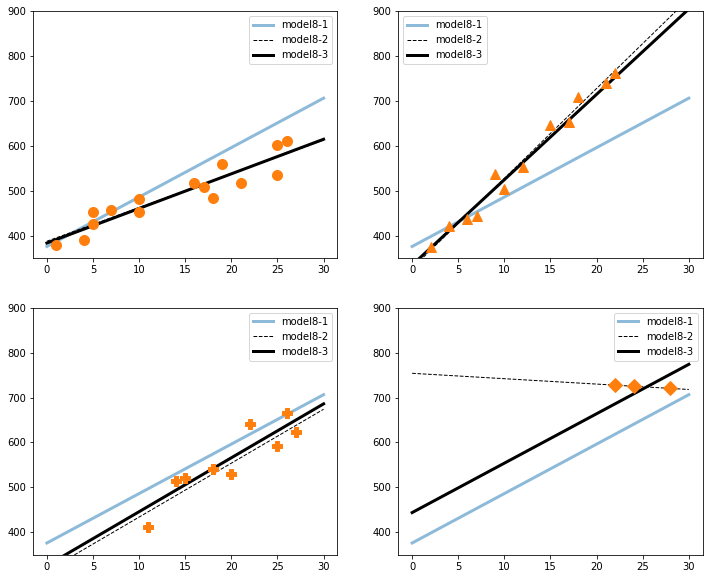

In [19]:
# Fig 8.4 right

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

styles = ['o', '^', 'P', 'D']


xx = np.linspace(0, 30, 11)
for i, ax in enumerate(np.ravel(axes), start=1):
    df_filtered = df[df["KID"]==i]
    ax.plot(xx, summary8_1.loc["a", "50%"] + summary8_1.loc["b", "50%"]*xx, linewidth=3, label="model8-1", alpha=0.5)
    ax.plot(xx, summary8_2.loc[f"a[{i}]", "50%"] + summary8_2.loc[f"b[{i}]", "50%"]*xx, linewidth=1, linestyle="--", color="k", label="model8-2")
    ax.plot(xx, summary8_3.loc[f"a[{i}]", "50%"] + summary8_3.loc[f"b[{i}]", "50%"]*xx, linewidth=3, linestyle="-", color="k", label="model8-3")
    ax.plot(df_filtered["X"], df_filtered["Y"], styles[i-1], markersize=10)
    ax.legend()
    ax.set_ylim(350,900)

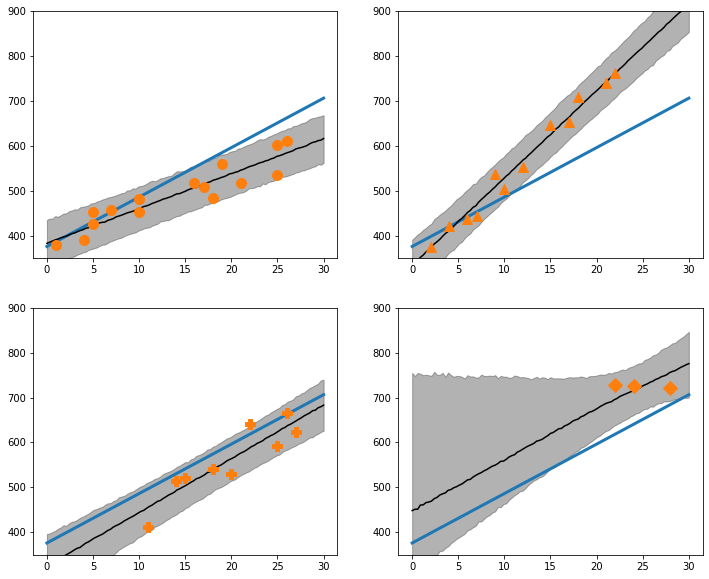

In [20]:
# exercise (2)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
styles = ['o', '^', 'P', 'D']

xx = np.linspace(0, 30, 101)
for KID, ax in enumerate(np.ravel(axes), start=1):
    df_filtered = df[df["KID"]==KID]
    ax.plot(xx, summary8_1.loc["a", "50%"] + summary8_1.loc["b", "50%"]*xx, linewidth=3)

    y_pred_samples = np.zeros((len(xx), len(fit8_3.stan_variable("a"))))
    for i, x in enumerate(xx):
        y_base = fit8_3.stan_variable("a")[:, KID - 1] + fit8_3.stan_variable("b")[:, KID - 1] * x
        y_pred_samples[i] = np.random.normal(loc=y_base, scale=fit8_3.stan_variable("s_Y"))
    y_pred_percentiles = np.percentile(y_pred_samples, [5.0, 50.0, 95.0], axis=1)
    
    ax.plot(xx, y_pred_percentiles[1], "k-")
    ax.fill_between(xx, y_pred_percentiles[0], y_pred_percentiles[2], color="k", alpha=0.3)

    ax.plot(df_filtered["X"], df_filtered["Y"], styles[KID-1], markersize=10)

    ax.set_ylim(350,900)